# 08/19/22 - Looking at the systematics results for J0029, strategizing for how to put it all together.

In [1]:
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle

from ppxf.kcwi_util import register_sauron_colormap
register_sauron_colormap()

obj_name = 'SDSSJ0330-0020'
obj_abbr = obj_name[4:9] # e.g. J0029

In [2]:
# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
# object directory
dir = f'{data_dir}mosaics/{obj_name}/'

save_dir = f'{dir}{obj_name}_systematics/'

In [36]:
V = np.genfromtxt(f'{save_dir}{obj_name}_systematics_V.txt', delimiter=',')
VD = np.genfromtxt(f'{save_dir}{obj_name}_systematics_VD.txt', delimiter=',')
dV = np.genfromtxt(f'{save_dir}{obj_name}_systematics_dV.txt', delimiter=',')
dVD = np.genfromtxt(f'{save_dir}{obj_name}_systematics_dVD.txt', delimiter=',')
chi2 = np.genfromtxt(f'{save_dir}{obj_name}_systematics_chi2.txt', delimiter=',')


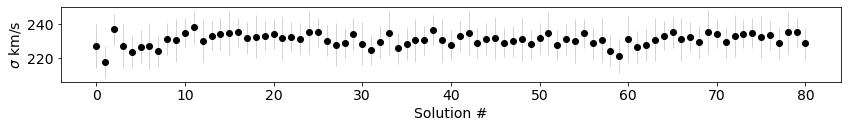

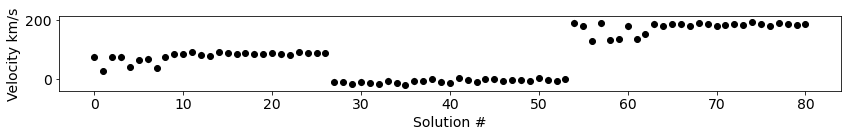

In [37]:
x = np.arange(VD.shape[1])
f, axarr = plt.subplots(1, sharex=True)
Nstar=0
y = VD[0]
dy = dVD[0]
axarr.errorbar(x, y, yerr=dy, fmt='o', color='black',
          ecolor='lightgray', elinewidth=1, capsize=0)
f.set_size_inches(12, 2)
plt.xlabel('Solution #')
plt.ylabel(r'$\sigma$ km/s')
plt.tight_layout()

x = np.arange(V.shape[1])
f, axarr = plt.subplots(1, sharex=True)
Nstar=0
y2 = V[0]
dy2 = dV[0]
axarr.errorbar(x, y2, yerr=dy, fmt='o', color='black',
          ecolor='lightgray', elinewidth=1, capsize=0)
f.set_size_inches(12, 2)
plt.xlabel('Solution #')
plt.ylabel(r'Velocity km/s')
plt.tight_layout()

In [38]:
def weighted_gaussian(xx, mu, sig, c2):
    yy = np.zeros(shape=xx.shape)
    for i in range(len(xx)):
        yy[i] = np.exp(-np.power(xx[i] - mu, 2.) / (2 * np.power(sig, 2.))) * np.exp(-0.5 * c2)
    return yy

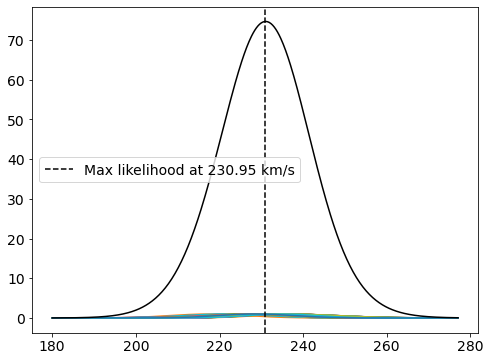

In [43]:
xx = np.linspace(180, np.max(VD)+10, 500, 1000)
c2 = chi2[0]

sum_gaussians = np.zeros(shape=xx.shape)

plt.figure(figsize=(8,6))

for i in range(len(y)):
    yy = weighted_gaussian(xx, y[i], dy[i], c2[i]) 
    sum_gaussians += yy

    plt.plot(xx, yy)    
    
plt.plot(xx, sum_gaussians, c='k')

max_likelihood = xx[sum_gaussians.argmax()]
plt.axvline(max_likelihood, c='k', linestyle='--', label=f'Max likelihood at {np.around(max_likelihood, 2)} km/s')
plt.legend()

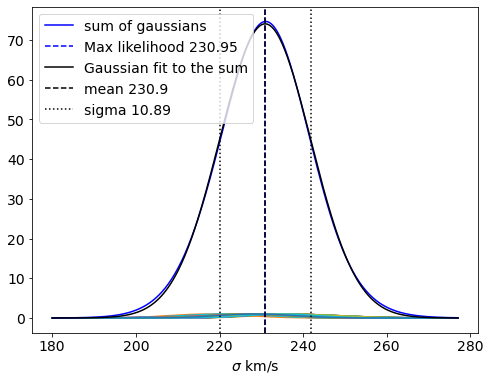

In [44]:
from scipy.optimize import curve_fit

parameters, covariance = curve_fit(weighted_gaussian, xx, sum_gaussians, p0=[210, 10, 3])
  
fit_mu = parameters[0]
fit_sigma = parameters[1]
fit_amp = parameters[2]
  
fit_y = weighted_gaussian(xx, fit_mu, fit_sigma, fit_amp)

plt.figure(figsize=(8,6))

for i in range(len(y)):
    yy = weighted_gaussian(xx, y[i], dy[i], c2[i]) 
    plt.plot(xx, yy)    

plt.plot(xx, sum_gaussians, '-', c='b', label='sum of gaussians')
plt.axvline(max_likelihood, c='b', linestyle='--', label=f'Max likelihood {np.around(max_likelihood, 2)}')
plt.plot(xx, fit_y, '-', c='k', label='Gaussian fit to the sum')
plt.axvline(fit_mu, linestyle='--', c='k', label=f'mean {np.around(fit_mu, 2)}')
plt.axvline(fit_mu - fit_sigma, linestyle=':', c='k', label=f'sigma {np.around(fit_sigma, 2)}')
plt.axvline(fit_mu + fit_sigma, linestyle=':', c='k')
plt.xlabel(r'$\sigma$ km/s')
plt.legend(loc='upper left')

In [45]:
# What if it doesn't have a Gaussian-ish profile? Try several and see how they all look.

def sum_gaussians_estimate_error (k_solutions, VD, dVD, chi2):
    
    # take x axis to be the 81 solutions
    x = np.arange(k_solutions)
    f, axarr = plt.subplots(1)
    y = VD
    dy = dVD
    
    # plot the 81 velocity disperions with error bars
    axarr.errorbar(x, y, yerr=dy, fmt='o', color='black',
              ecolor='lightgray', elinewidth=1, capsize=0)
    f.set_size_inches(12, 2)
    plt.xlabel('Solution #')
    plt.ylabel(r'$\sigma$ km/s')
    plt.tight_layout()
    plt.show()
        
    VD_min = VD.min() - dVD.max() * 3
    VD_max = VD.max() + dVD.max() * 3
    mu_0 = VD.mean()
    sigma_0 = dVD.mean()
    
    # sum by weighted velocity disperions profiles
    
    xx = np.linspace(VD_min, VD_max, 1000)
    c2 = chi2

    plt.figure(figsize=(8,6))
    plt.xlabel(r'$\sigma$ km/s')
    
    sum_gaussians = np.zeros(shape=xx.shape)
    
    for i in range(len(y)):
        yy = weighted_gaussian(xx, y[i], dy[i], c2[i]) 
        plt.plot(xx, yy)    
        sum_gaussians += yy
    
    plt.show()
        
    amp_0 = sum_gaussians.max()
    max_likelihood = xx[sum_gaussians.argmax()]

    # fit the summed profile with a Gaussian to get sigma for the bin
    
    parameters, covariance = curve_fit(weighted_gaussian, xx, sum_gaussians, p0=[mu_0, sigma_0, amp_0])
  
    fit_mu = parameters[0]
    fit_sigma = parameters[1]
    fit_amp = parameters[2]

    fit_y = weighted_gaussian(xx, fit_mu, fit_sigma, fit_amp)

    plt.figure(figsize=(8,6))
    
    for i in range(len(y)):
        yy = weighted_gaussian(xx, y[i], dy[i], c2[i]) 
        plt.plot(xx, yy)    
        
    # plot it all

    plt.plot(xx, sum_gaussians, '-', c='b', label='sum of gaussians')
    plt.axvline(max_likelihood, c='b', linestyle='--', label=f'Max likelihood {np.around(max_likelihood, 2)}')
    plt.plot(xx, fit_y, '-', c='k', label='Gaussian fit to the sum')
    plt.axvline(fit_mu, linestyle='--', c='k', label=f'mean {np.around(fit_mu, 2)}')
    plt.axvline(fit_mu - fit_sigma, linestyle=':', c='k', label=f'sigma {np.around(fit_sigma, 2)}')
    plt.axvline(fit_mu + fit_sigma, linestyle=':', c='k')
    plt.xlabel(r'$\sigma$ km/s')
    plt.legend(loc='upper left')
    plt.show()

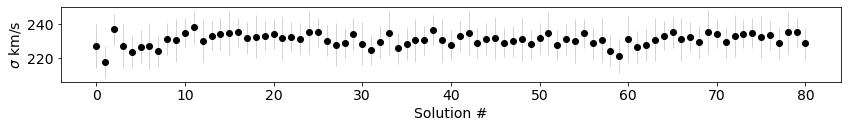

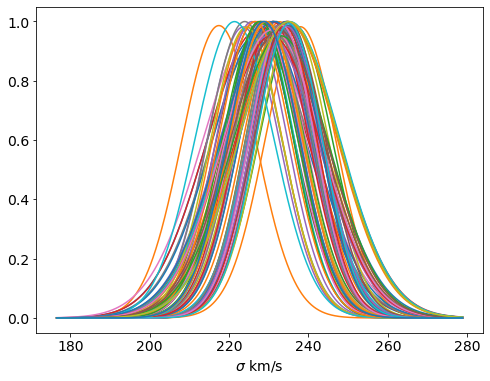

/local/shawnknabel/anaconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


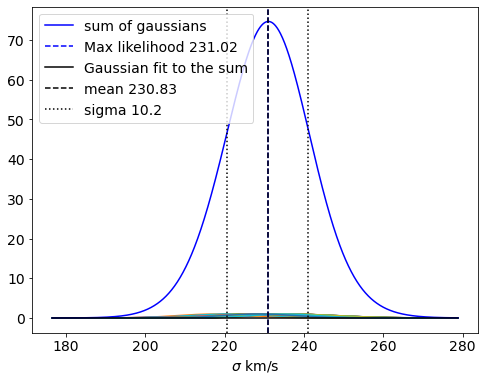

In [46]:
sum_gaussians_estimate_error(81, VD[0], dVD[0], chi2[0])

# I redid the fit so that it worked properly with the right wavelength range (< 4150 A), but the stuff below still shows the previous fit, with the horrible fitting.

(array([ 2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  3.,  6.,  0.,  0.,  9.,  0., 18., 36.]),
 array([0.01120089, 0.01121363, 0.01122636, 0.0112391 , 0.01125183,
        0.01126457, 0.0112773 , 0.01129004, 0.01130277, 0.01131551,
        0.01132824, 0.01134098, 0.01135371, 0.01136645, 0.01137919,
        0.01139192, 0.01140466, 0.01141739, 0.01143013, 0.01144286,
        0.0114556 , 0.01146833, 0.01148107, 0.0114938 , 0.01150654,
        0.01151928, 0.01153201, 0.01154475, 0.01155748, 0.01157022,
        0.01158295, 0.0115

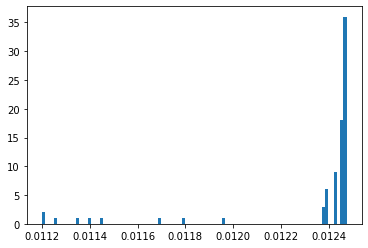

In [12]:
plt.hist(np.exp(-0.5*chi2[0])/np.sum(np.exp(-0.5*chi2[0])), bins=100)

In [14]:
hi_VD = np.where(VD[0] > 350)
hi_VD

(array([ 0,  6,  9, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54,
        60, 63, 69, 72, 78]),)

In [25]:
import glob

models_names = np.zeros(81).astype(str)

i = 0
for file in glob.glob(f'{save_dir}**/*l*.pkl'):
    model = file[-41:-33]
    models_names[i] = model
    i = i+1
    
models_names = np.sort(models_names)
    
np.savetxt(f'{data_dir}systematics_models_names.txt', models_names, delimiter=',', fmt='%s')

In [30]:
models_names[hi_VD]

array(['l0a0d0w0', 'l0a0d2w0', 'l0a1d0w0', 'l0a1d2w0', 'l0a2d0w0',
       'l0a2d1w0', 'l0a2d2w0', 'l1a0d0w0', 'l1a0d1w0', 'l1a0d2w0',
       'l1a1d0w0', 'l1a1d1w0', 'l1a1d2w0', 'l1a2d0w0', 'l1a2d1w0',
       'l1a2d2w0', 'l2a0d0w0', 'l2a0d2w0', 'l2a1d0w0', 'l2a1d2w0',
       'l2a2d0w0', 'l2a2d2w0'], dtype='<U32')

In [31]:
plt.rcParams.update({'font.size': 14})

In [32]:
syst_dir = f'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/mosaics/{obj_name}/{obj_name}_systematics/'

In [34]:
# ooooooooooooooooooooooooooooooohhhhhhhhhhhhhhhhhhhh this is why I did wavelength ranges to 410 nm in the kinematics script.


Velocity 29.47967158693868, Velocity dispersion 396.9163493867769


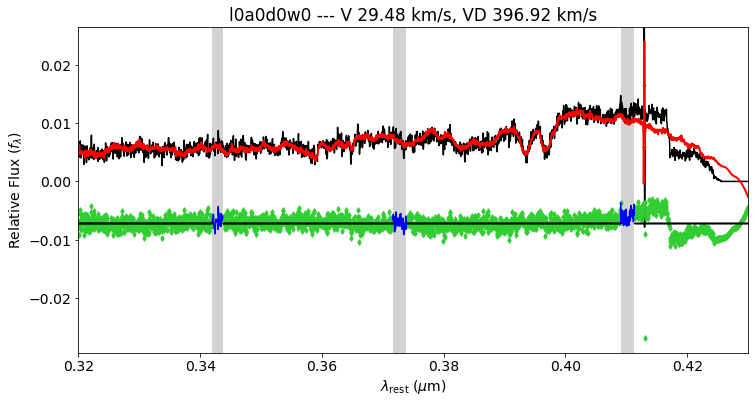

Velocity 48.42027438425427, Velocity dispersion 458.97964175244925


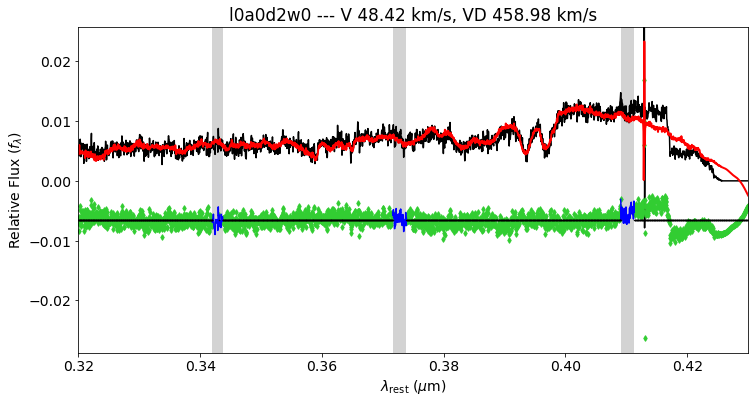

Velocity 35.33598263293422, Velocity dispersion 396.81234525165553


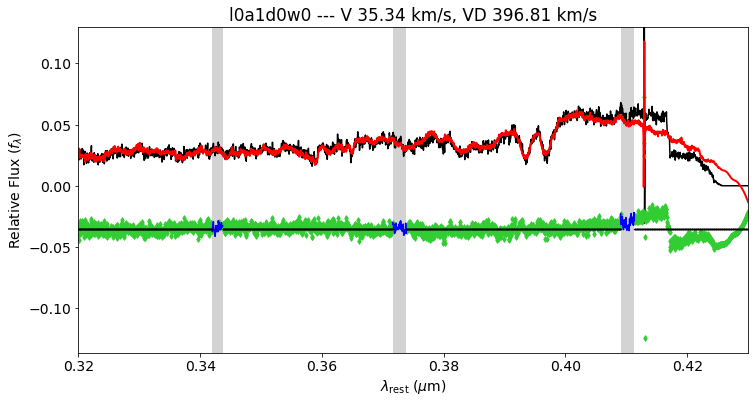

Velocity 50.63900401892995, Velocity dispersion 457.8169001034157


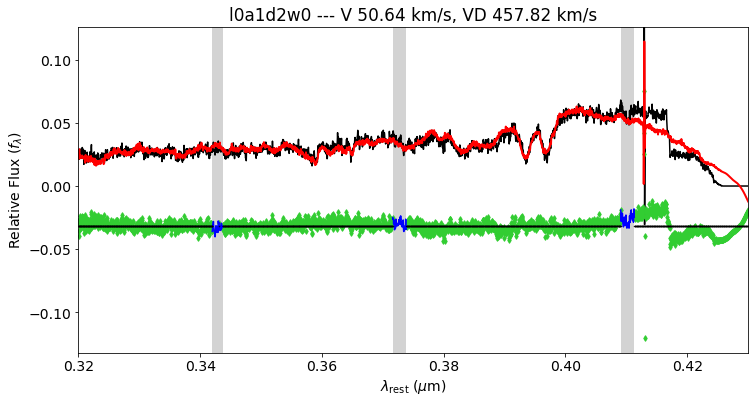

Velocity 45.22575045757765, Velocity dispersion 391.7178279167873


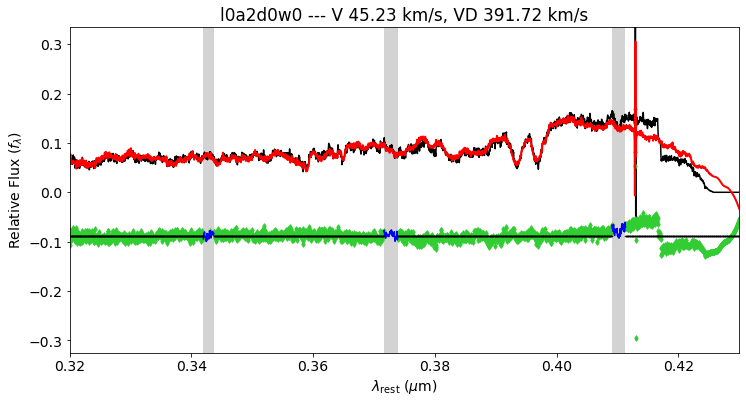

Velocity 47.96604404179575, Velocity dispersion 368.27611962463664


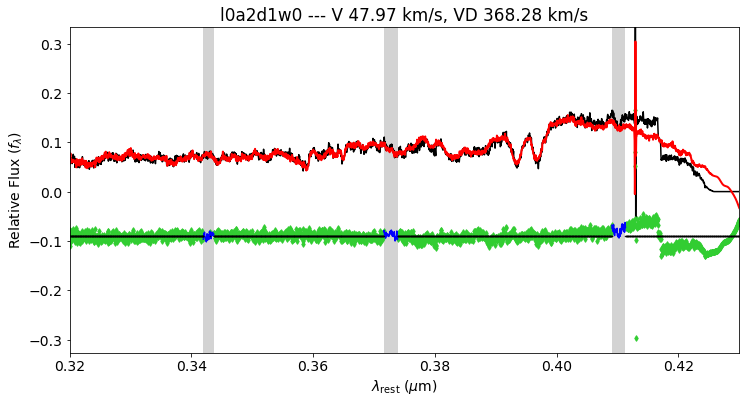

Velocity 58.20699765297054, Velocity dispersion 448.7843018457197


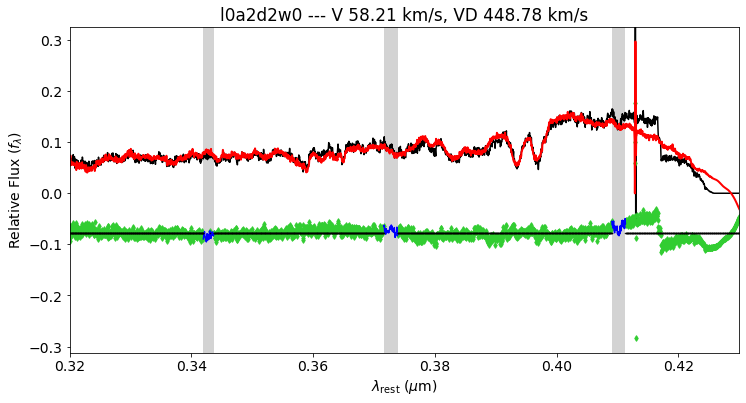

Velocity -73.25172681993338, Velocity dispersion 397.7094186952363


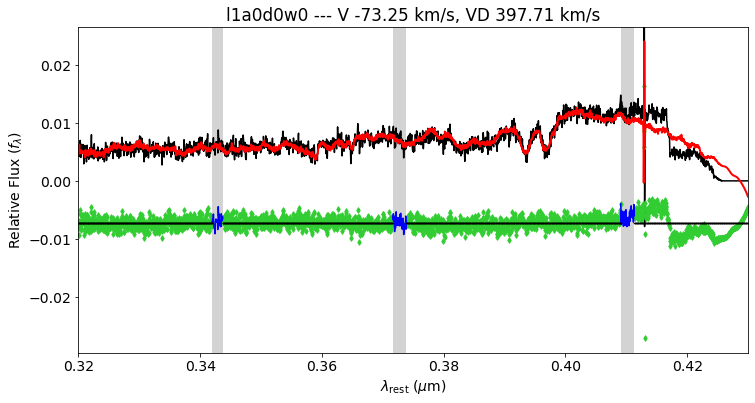

Velocity -67.76622758170106, Velocity dispersion 377.90977984105706


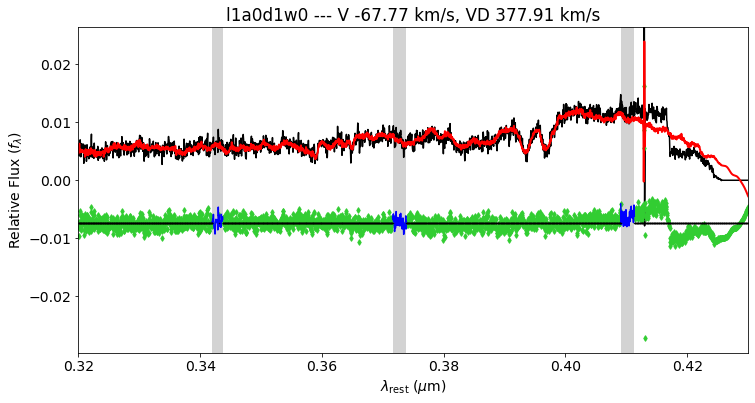

Velocity -44.012166834228594, Velocity dispersion 474.8227120170129


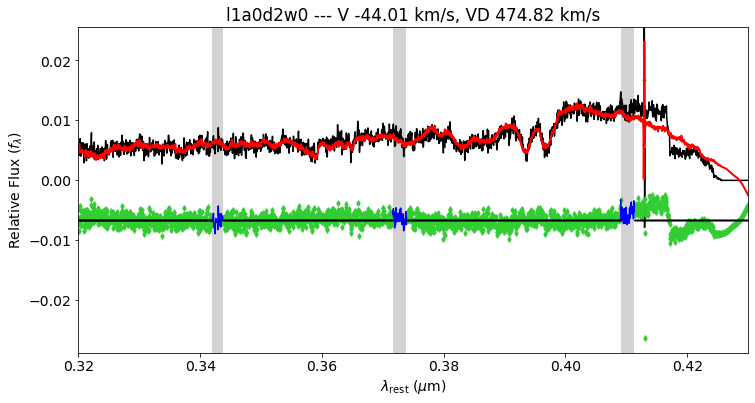

Velocity -66.97619622497129, Velocity dispersion 393.70649294108426


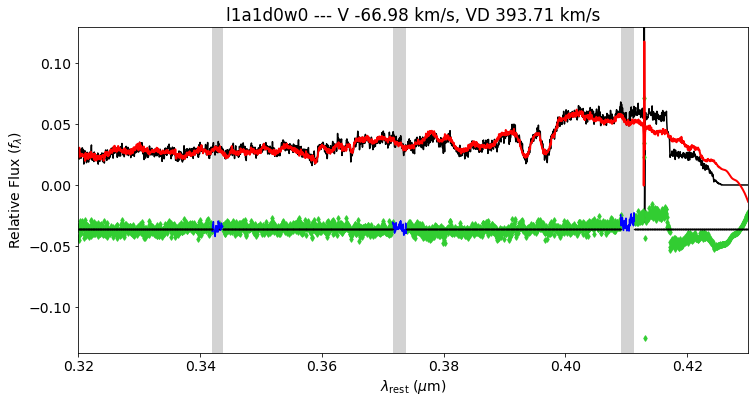

Velocity -65.22052476299915, Velocity dispersion 376.53256421388187


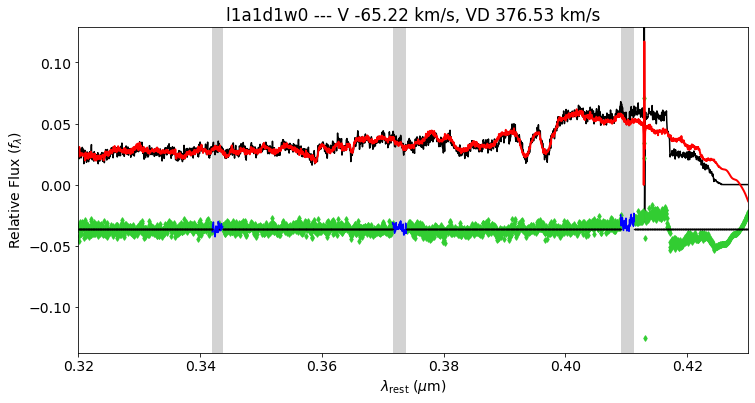

Velocity -39.3688281754126, Velocity dispersion 468.4302640584893


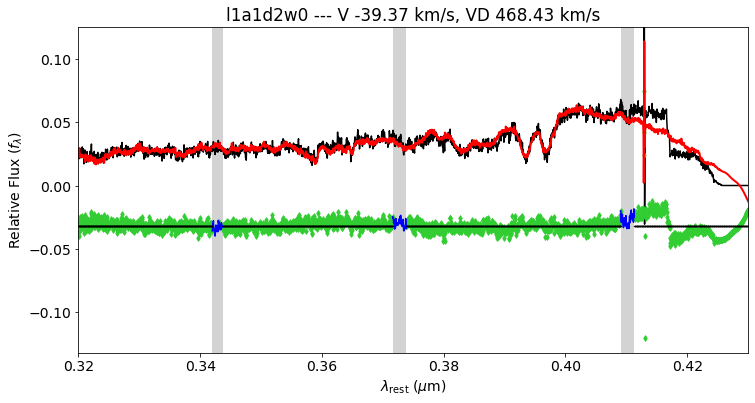

Velocity -58.31249098247675, Velocity dispersion 383.86608595342665


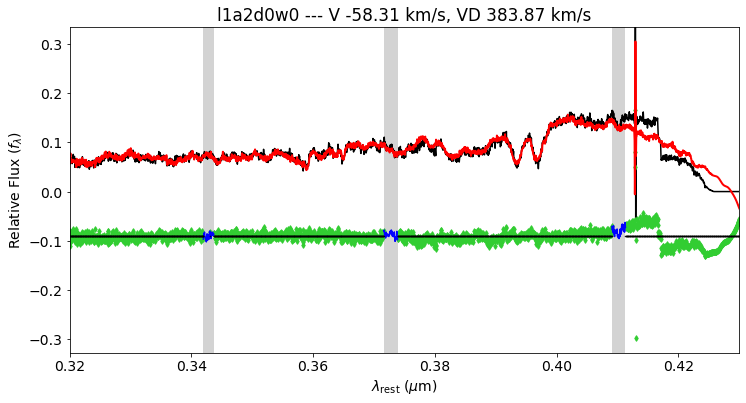

Velocity -55.30198622126824, Velocity dispersion 368.73463919646207


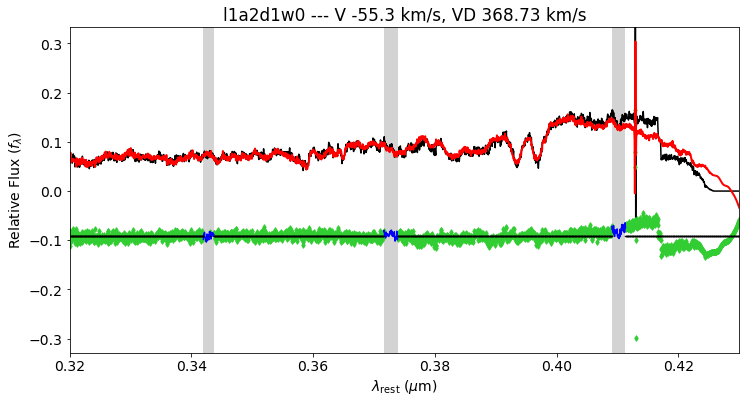

Velocity -33.37484383222532, Velocity dispersion 453.9606361741464


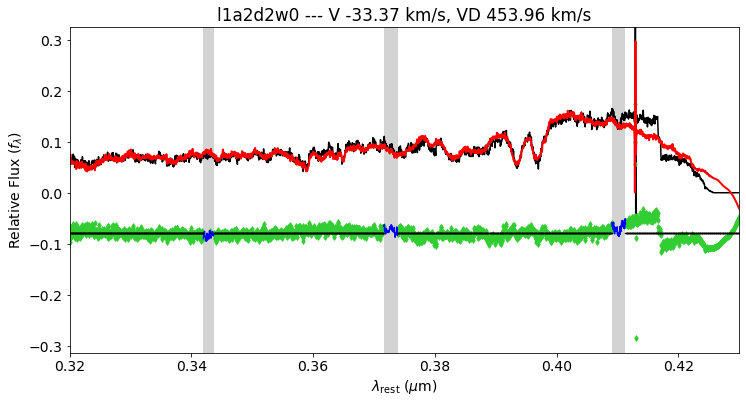

Velocity 151.5309160492998, Velocity dispersion 392.4671411147723


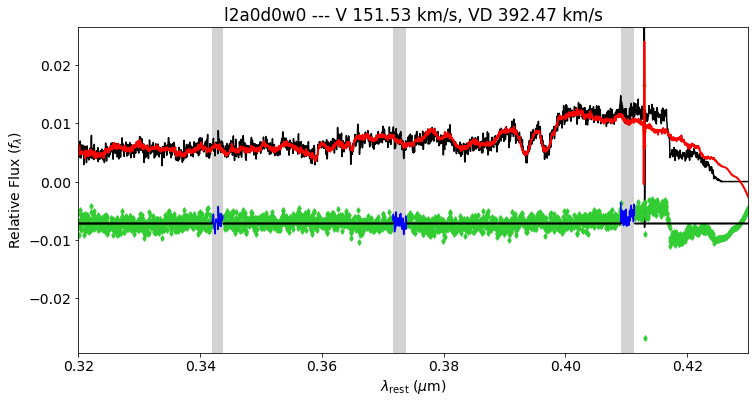

Velocity 177.34720239237362, Velocity dispersion 427.5590129035277


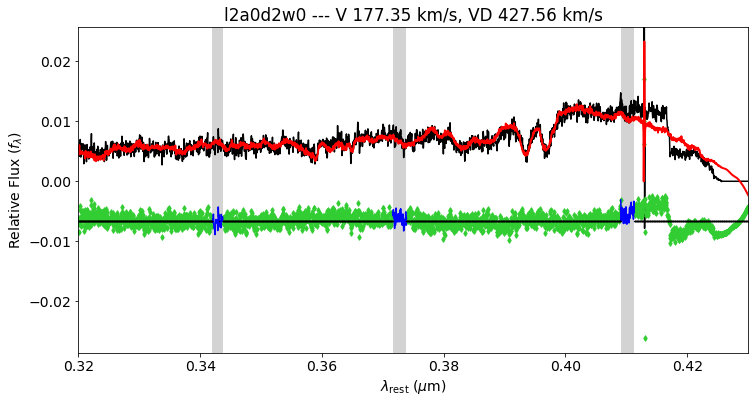

Velocity 158.15417615054508, Velocity dispersion 392.10711349770713


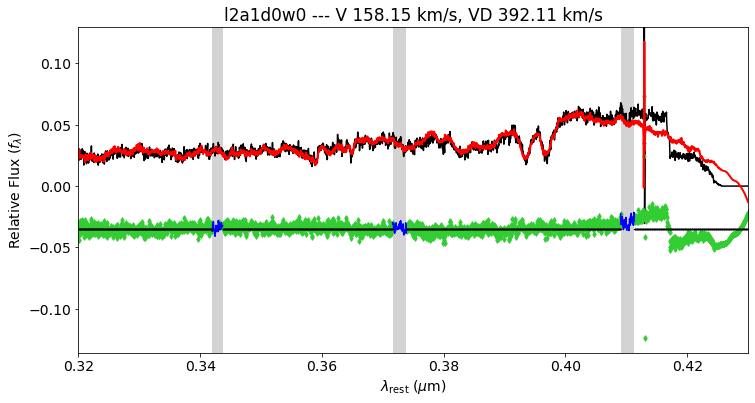

Velocity 177.9407816370652, Velocity dispersion 429.8381405044998


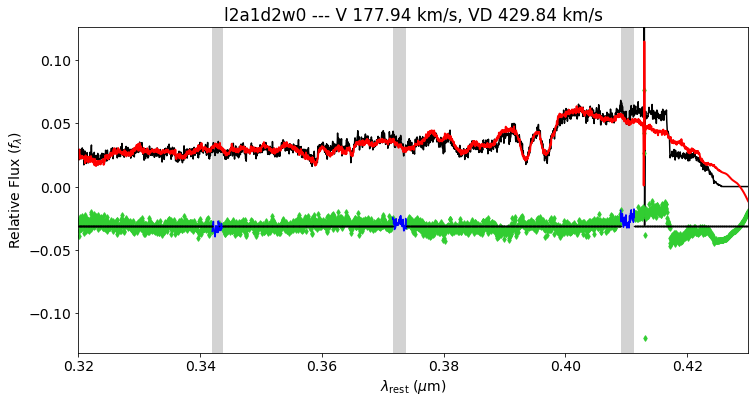

Velocity 170.0017010614128, Velocity dispersion 383.6481142005678


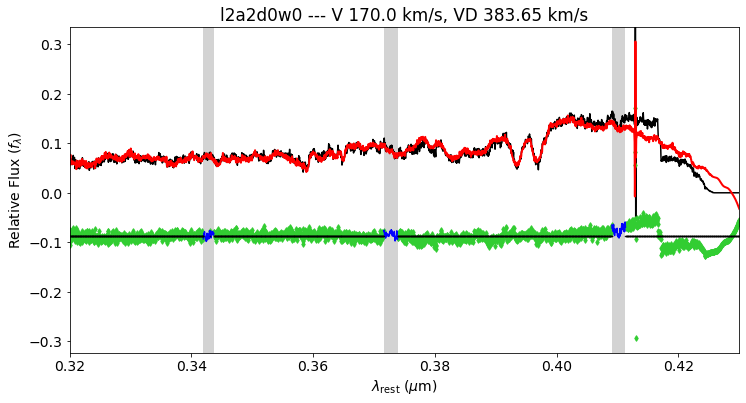

Velocity 186.25310717528944, Velocity dispersion 419.9491489118052


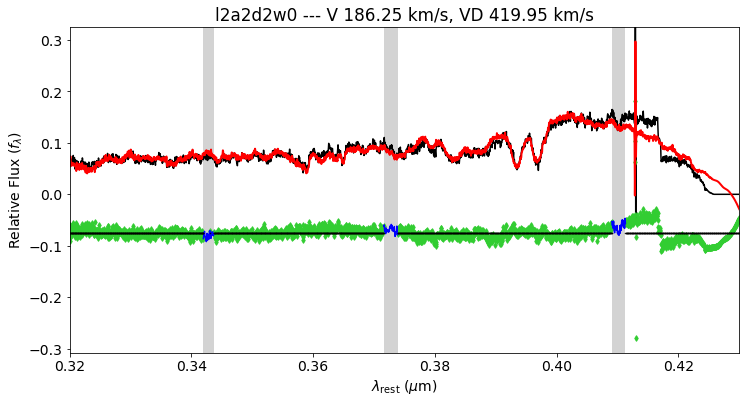

In [33]:
for model in models_names[hi_VD]:
    file = open(f'{syst_dir}{model}/global_template_spectrum_fit.pkl','rb') 
    picle = pickle.load(file)
    print(f'Velocity {picle.sol[0]}, Velocity dispersion {picle.sol[1]}')
    plt.figure(figsize=(12,6))
    picle.plot()
    plt.xlim(0.32, 0.43)
    plt.title(f'{model} --- V {np.around(picle.sol[0], 2)} km/s, VD {np.around(picle.sol[1],2)} km/s')
    plt.show()
    

Velocity 29.47967158693868, Velocity dispersion 396.9163493867769


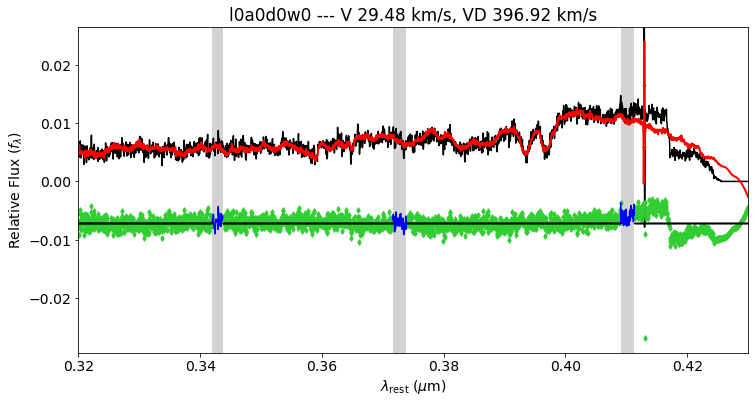

Velocity 141.94616798102612, Velocity dispersion 260.139252237553


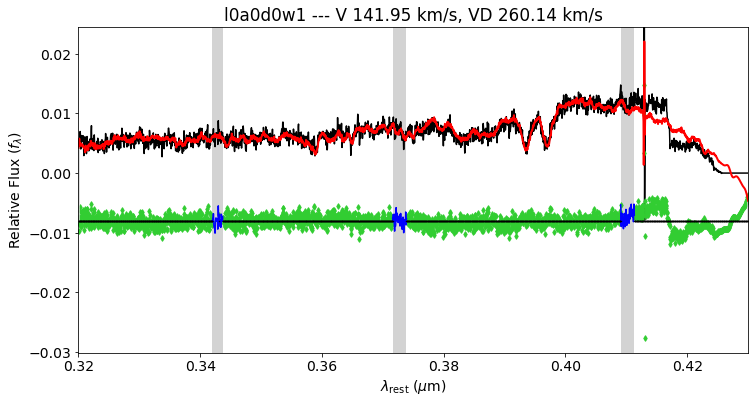

Velocity 97.96630858202052, Velocity dispersion 327.39061708498633


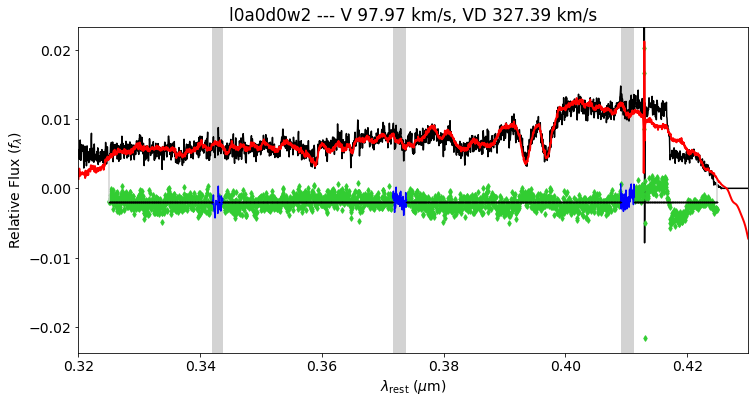

Velocity 40.916332395122346, Velocity dispersion 360.611423473552


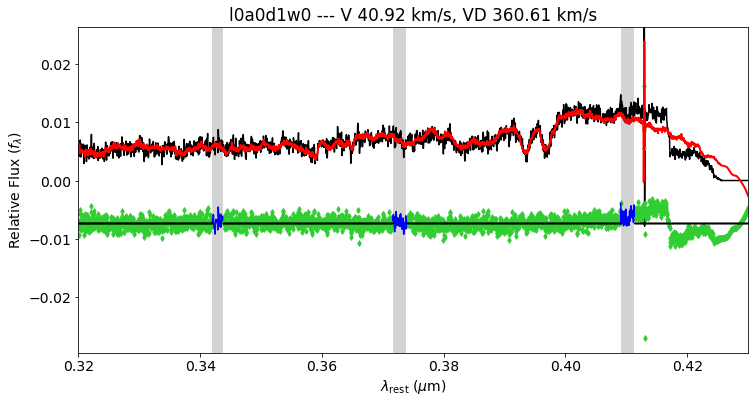

Velocity 121.06791284507189, Velocity dispersion 240.7597494298918


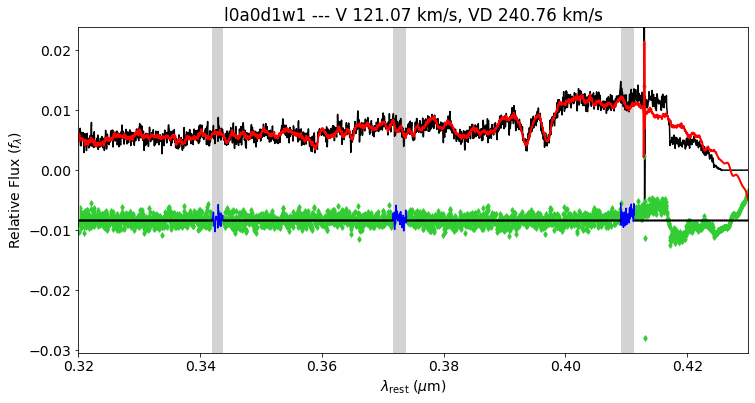

In [35]:
for model in models_names[:5]:
    file = open(f'{syst_dir}{model}/global_template_spectrum_fit.pkl','rb') 
    picle = pickle.load(file)
    print(f'Velocity {picle.sol[0]}, Velocity dispersion {picle.sol[1]}')
    plt.figure(figsize=(12,6))
    picle.plot()
    plt.xlim(0.32, 0.43)
    plt.title(f'{model} --- V {np.around(picle.sol[0], 2)} km/s, VD {np.around(picle.sol[1],2)} km/s')
    plt.show()
    